# 확률적 경사 하강법

## 키워드
####**점진적 학습**
 - Incremental learning, 온라인 학습(Online learning)
 - 학습이 끝나 제품화된 모델에 대하여, 미니배치(Mini-batch)라 부르는 작은 묶음 단위의 데이터를 주입하여 모델을 학습시키는 방법
 - 새로운 데이터 샘플을 학습하면, 학습이 끝난 데이터는 더 이상 필요하지 않기 때문에 보관하지 않아도 되므로, 저장 공간을 많이 아낄 수 있음

**확률적 경사 하강법**(Stochastic Gradient Descent)
 - 훈련 세트에서 샘플 하나씩 꺼내 손실 함수의 경사를 따라 최적의 모델을 찾는 알고리즘

**미니배치 경사 하강법**(minibatch gradient descent)
 - 샘플을 하나씩 사용하지 않고 여러 개를 사용

**배치 경사 하강법**(batch gradient descent)
 - 한번에 전체 샘플을 사용

####**손실 함수**
 - loss function
 - 샘플 하나에 대한 손실을 정의
 - 확률적 경사 하강법이 최적화할 대상
 - 이진 분류 - 로지스틱 회귀(또는 이진 크로스앤트로피) 손실 함수를 사용
 - 다중 분류 - 크로스엔트로피 손실 함수를 사용
 - 회귀 문제 - 평균 제곱 오차 손실 함수를 사용

####**에포크**
 - epoch
 - 확률적 경사 하강법에서 전체 샘플을 모두 사용하는 한 번 반복을 의미
 - 일반적으로 경사 하강법 알고리즘은 수십에서 수백 번이 에포크를 반복



## SGDClassifier

###0. 데이터 준비

####1) 데이터 불러오기

In [1]:
import pandas as pd

fish = pd.read_csv('https://bit.ly/fish_csv_data')

####2) 입력 데이터와 타깃 데이터로 분리

In [2]:
fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
fish_target = fish['Species'].to_numpy()

####3) 훈련 세트와 테슽 세트로 분리

In [3]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    fish_input, fish_target, random_state=42)

####4) 표준화 전처리

In [4]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

###1. SGDClassifier 클래스 객체를 생성하고 훈련
 - loss 매개변수 : 손실 함수의 종류를 지정 ('log'는 로지스틱 손실 함수)
 - max_iter 매개변수 : 수행할 에포크 횟수 지정

In [6]:
from sklearn.linear_model import SGDClassifier

In [7]:
sc = SGDClassifier(loss='log', max_iter=10, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


ConvergenceWarning 경고가 뜨는 이유
 - 모델이 충분히 수렴하지 않았다는 의미
 - max_iter 매개변수의 값을 늘려 주면 해결됨

###2. 훈련한 모델을 추가로 더 훈련
 - partial_fit()

In [8]:
sc.partial_fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8151260504201681
0.825


아직 점수가 낮지만 에포크를 한 번 더 실행하니 정확도가 향상된 것을 볼 수 있다.

## 에포크와 과대/과소적합
확률적 경사 하강법을 이용한 모델은 에포크 횟수에 따라 과소적합이나 과대적합이 될 수 있다.
 - 적은 에포크 횟수로 훈련 → 과소적합
 - 너무 많은 에포크 횟수로 훈련 → 과대적합

**조기 종료**(early stopping)
 - 과대적합이 시작하기 전에 훈련을 멈추는 것

###3. 에포크를 300번 훈련하는 동안의 점수를 그래프로 출력

In [9]:
import numpy as np

sc = SGDClassifier(loss='log', random_state=42)

train_score = []
test_score = []

classes = np.unique(train_target)

In [10]:
for _ in range(0, 300):
    sc.partial_fit(train_scaled, train_target, classes=classes)
    
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

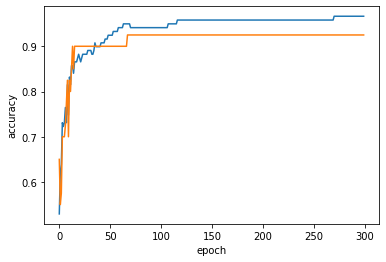

In [11]:
import matplotlib.pyplot as plt

plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

적절한 에포크 반복 횟수는 100으로 보인다.

### 4. max_iter을 100으로 설정 후 다시 훈련
 - tol 매개변수 : SGDClassifier는 일정 에포크 동안 성능이 향상되지 않으면 더 훈련하지 않고 자동으로 멈춤. 향상할 최솟값 지정

In [12]:
sc = SGDClassifier(loss='log', max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.957983193277311
0.925


5. 힌지 손실을 이용해서 훈련
 - loss 매개변수 : 기본값은 hinge(힌지 손실 또는 서포트 벡터 머신)

In [13]:
sc = SGDClassifier(loss='hinge', max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.9495798319327731
0.925
